# Analiza dotacji KPO — HoReCa
**Źródło danych:** mapa-kpo.pl    
_Data analizy: 2025-08-09_

1. Pobranie danych z mapa-kpo.pl (scraping plików `.js` z JSON).
2. Czyszczenie polskich znaków.
3. Połączenie rekordów w jeden DataFrame.
4. Analiza tytułów:
   - najczęstsze słowa i bigramy,
   - wybrane słowa-klucze (*jachty*, *rowery*, *meble*, *ekspres*),
   - Word Cloud.
5. Heatmapa lokalizacji dotacji.
6. Statystyki:
   - średnia/mediana dotacji,
   - ranking miast i województw,
   - podział wg słów wartościujących (*dywersyfikacja*, *rozwój*, *modernizacja*).

In [26]:
from collections import Counter
from collections import OrderedDict
from collections import defaultdict
import ast
import json
import re

from folium.plugins import HeatMap
from ftfy import fix_text
from wordcloud import WordCloud
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [27]:
#Scrape najpierw HoReCa1
url = "https://mapa-kpo.pl/_next/static/chunks/285.28cf8ff78120ff6b.js"
r = requests.get(url)
text = r.text

# wyciągnij to, co jest w JSON.parse('...')
m = re.search(r"JSON\.parse\(\s*'(.+?)'\s*\)", text, re.DOTALL)
if not m:
    raise ValueError("Nie znalazłem JSON.parse(...)")

raw_escaped = m.group(1)

# od-escape'uj tak, jak w JS (np. \" -> ", \\n -> \n)
json_text = bytes(raw_escaped, "utf-8").decode("unicode_escape")

# teraz ładujemy już czysty JSON
data = json.loads(json_text)

print("Liczba rekordów:", len(data))
print("Pierwszy rekord:", data[0])


Liczba rekordów: 1885
Pierwszy rekord: {'id': '56494FAA0D000002', 'placeId': 'V52W4o_vUd0', 'coords': {'lat': 51.7632335, 'long': 19.407112599999998}, 'title': 'Wzmocnienie odpornoÅ\x9bci firmy OZDOBA I SYN S.C. poprzez inwestycje w nowe usÅ\x82ugi oraz zielonÄ\x85 i cyfrowÄ\x85 transformacjÄ\x99', 'value': 292095, 'name': 'OZDOBA I SYN S.C.', 'state': 'Å\x81ÓDZKIE', 'city': 'Å\x81ódÅº', 'street': None, 'apartamentNumber': '8', 'postalCode': '94-302'}


In [28]:
#Scrape najpierw HoReCa2
url2 = "https://mapa-kpo.pl/_next/static/chunks/511.8e3cb837bb107d05.js"
r2 = requests.get(url2)
text2 = r2.text

m2 = re.search(r"JSON\.parse\(\s*'(.+?)'\s*\)", text2, re.DOTALL)
if not m2:
    raise ValueError("Nie znalazłem JSON.parse(...) w drugim pliku")

raw_escaped2 = m2.group(1)

# od-escape'uj sekwencje typu \" \n \uXXXX
json_text2 = bytes(raw_escaped2, "utf-8").decode("unicode_escape")

# parse do listy/dict -> spodziewamy się listy rekordów
data2 = json.loads(json_text2)

print("Liczba rekordów w data2:", len(data2))
print("Pierwszy rekord data2:", data2[0])

Liczba rekordów w data2: 867
Pierwszy rekord data2: {'id': '56495046BB000001', 'placeId': 'cKdodKCLsxY', 'coords': {'lat': 50.3673472, 'long': 20.8867698}, 'title': 'ZwiÄ\x99kszenie odpornoÅ\x9bci przedsiÄ\x99biorstwa na sytuacje kryzysowe poprzez rozszerzenie zakresu usÅ\x82ug i oferty sprzedaÅ¼owej dla przyciÄ\x85gniÄ\x99cia szerszej grupy klientów â\x80\x93 mieszkaÅ\x84ców, turystów i kuracjuszy przebywajÄ\x85cych w Solcu Zdroju w województwie Å\x9bwiÄ\x99tokrzyskim.', 'value': 229529, 'name': 'Aneta Bednarska', 'state': 'Å\x9aWIÄ\x98TOKRZYSKIE', 'city': 'Solec-Zdrój', 'street': '1 Maja', 'apartamentNumber': '1', 'postalCode': '28-131'}


In [29]:
# łączymy
df = pd.DataFrame(data + data2)

# deduplikacja po id
if "id" in df.columns:
    df = df.drop_duplicates(subset="id").reset_index(drop=True)

In [30]:
df.head()

,id,placeId,coords,title,value,name,state,city,street,apartamentNumber,postalCode
0,56494FAA0D000002,V52W4o_vUd0,"{'lat': 51.7632335, 'long': 19.407112599999998}",Wzmocnienie odpornoÅci firmy OZDOBA I SYN S.C...,292095,OZDOBA I SYN S.C.,ÅÓDZKIE,ÅódÅº,None,8,94-302
1,56494FAA0D000003,V52W4o_vUd0,"{'lat': 50.345264699999994, 'long': 18.9163078}",Wzmocnienie odpornoÅci Restauracji Pod CzaplÄ...,305690,Restauracja Pod CzaplÄ Dobrowolscy spóÅka cy...,ÅLÄSKIE,Bytom,StanisÅawa Moniuszki,8,41-902
2,56494FAA0D000004,V52W4o_vUd0,"{'lat': 50.023457099999995, 'long': 18.6854303...",Inwestycja spóÅki WIOLETTA I MICHAÅ LISZOWSC...,113032,WIOLETTA I MICHAÅ LISZOWSCY SPÓÅKA CYWILNA,ÅLÄSKIE,Å»ory,Józefa MikoÅajca,17,44-240
3,56494FAA0D000005,V52W4o_vUd0,"{'lat': 50.315061799999995, 'long': 18.7831787...",Projekt ZIELONA OLIWKA: Rewolucja w gastronomi...,416997,PRZEDSIÄBIORSTWO USÅUGOWO-HANDLOWE 'IWO' IWO...,ÅLÄSKIE,Zabrze,JagielloÅska,38,41-800
4,56494FAA0D000006,V52W4o_vUd0,"{'lat': 50.8481452, 'long': 17.461323099999998}",Rozszerzenie oferty produktowej przedsiÄbiors...,214023,SÅodki Przystanek Monika Krzyszczuk,OPOLSKIE,Brzeg,KsiÄdza Makarskiego,37,49-300


In [31]:
# ftfy - czyszczenie problemów z polskimi znakami

df_fixed = df.copy()

TEXT_COLS = [c for c in df_fixed.columns if df_fixed[c].dtype == 'object']

for c in TEXT_COLS:
    df_fixed[c] = df_fixed[c].astype(str).apply(fix_text)

print(df_fixed.loc[:5, ['state','city','title']].to_string(index=False))

   state           city                                                                                                                                                                                                                                                                                                                            title
 ŁÓDZKIE           Łódź                                                                                                                                                                                                             Wzmocnienie odporności firmy OZDOBA I SYN S.C. poprzez inwestycje w nowe usługi oraz zieloną i cyfrową transformację
 ŚLĄSKIE          Bytom                                                                                                                                                                                                                  Wzmocnienie odporności Restauracji Pod Czaplą działającej w regionie 4 poprze

In [32]:
df_fixed.head()

,id,placeId,coords,title,value,name,state,city,street,apartamentNumber,postalCode
0,56494FAA0D000002,V52W4o_vUd0,"{'lat': 51.7632335, 'long': 19.407112599999998}",Wzmocnienie odporności firmy OZDOBA I SYN S.C....,292095,OZDOBA I SYN S.C.,ŁÓDZKIE,Łódź,None,8,94-302
1,56494FAA0D000003,V52W4o_vUd0,"{'lat': 50.345264699999994, 'long': 18.9163078}",Wzmocnienie odporności Restauracji Pod Czaplą ...,305690,Restauracja Pod Czaplą Dobrowolscy spółka cywilna,ŚLĄSKIE,Bytom,Stanisława Moniuszki,8,41-902
2,56494FAA0D000004,V52W4o_vUd0,"{'lat': 50.023457099999995, 'long': 18.6854303...",Inwestycja spółki WIOLETTA I MICHAŁ LISZOWSCY ...,113032,WIOLETTA I MICHAŁ LISZOWSCY SPÓŁKA CYWILNA,ŚLĄSKIE,Żory,Józefa Mikołajca,17,44-240
3,56494FAA0D000005,V52W4o_vUd0,"{'lat': 50.315061799999995, 'long': 18.7831787...",Projekt ZIELONA OLIWKA: Rewolucja w gastronomi...,416997,PRZEDSIĘBIORSTWO USŁUGOWO-HANDLOWE 'IWO' IWONA...,ŚLĄSKIE,Zabrze,Jagiellońska,38,41-800
4,56494FAA0D000006,V52W4o_vUd0,"{'lat': 50.8481452, 'long': 17.461323099999998}",Rozszerzenie oferty produktowej przedsiębiorst...,214023,Słodki Przystanek Monika Krzyszczuk,OPOLSKIE,Brzeg,Księdza Makarskiego,37,49-300


In [33]:
df_fixed.to_csv('kpo_horeca_09aug2025.csv')

In [34]:
polish_stopwords = {
    "i", "oraz", "a", "w", "z", "na", "że", "to", "nie", "tak", "jest",
    "się", "o", "po", "jak", "ale", "dla", "co", "od", "za", "czy", "by",
    "tylko", "być", "go", "też", "bo", "u", "są", "który", "która", "które",
    "już", "ma", "przez", "było", "była", "temu", "więc", "mnie", "ich",
    "także", "ten", "tym", "nawet", "którzy", "sobie", "nikt", "dalej",
    "będzie", "tego", "jeszcze", "teraz", "może", "sie",
    "żeby", "tam", "trzeba", "mam"
}

# 1) Łączenie wszystkich tytułów w jeden string
titles_text = " ".join(df_fixed['title'].dropna().astype(str))

# 2) Na małe litery
titles_text = titles_text.lower()

# 3) Usunięcie interpunkcji i cyfr
titles_text = re.sub(r"[^a-ząćęłńóśźż\s]", " ", titles_text)

# 4) Podział na słowa
words = titles_text.split()

# 5) Usunięcie stop-słów
filtered_words = [w for w in words if w not in polish_stopwords]

# 6) Zliczenie najczęstszych
word_counts = Counter(filtered_words)

# 7) Top 20
top_words = word_counts.most_common(20)

# Wyświetlenie wyników
for word, freq in top_words:
    print(f"{word}: {freq}")

działalności: 1834
poprzez: 1284
dywersyfikacja: 1124
usług: 832
region: 825
firmy: 823
rozszerzenie: 804
odporności: 752
usługi: 740
wprowadzenie: 683
przedsiębiorstwa: 619
województwie: 594
oferty: 475
nowych: 465
regionie: 448
nowej: 420
zwiększenie: 413
do: 407
województwa: 405
kryzysowe: 341


In [35]:
# Szukamy 
# słowa-klucze z odmianami w regexach
patterns = {
    "jacht": r"\bjacht\w*\b",
    "meble": r"\bmebl\w*\b",
    "ekspres": r"\bekspres\w*\b",
    "basen": r"\bbasen\w*\b",
    "spa": r"\bspa\b",
    "sauna": r"\bsaun\w*\b",
    "quad": r"\bquad\w*\b",
    "rower": r"\brower\w*\b",
    "łódź": r"\błód\w*\b"
}

In [36]:
results = {}

for key, pattern in patterns.items():
    mask = df_fixed['title'].str.lower().str.contains(pattern, flags=re.IGNORECASE, na=False, regex=True)
    results[key] = mask.sum()

# wyniki jako DataFrame
df_counts = pd.DataFrame(list(results.items()), columns=["Słowo", "Liczba wniosków"])
df_counts = df_counts.sort_values(by="Liczba wniosków", ascending=False)

print(df_counts)

     Słowo  Liczba wniosków
7    rower              117
8     łódź              105
4      spa               97
5    sauna               29
0    jacht               26
3    basen               13
6     quad                3
2  ekspres                1
1    meble                0


In [37]:
mask_rower = df_fixed['title'].str.lower().str.contains(r"\brower\w*\b", flags=re.IGNORECASE, na=False, regex=True)

# wyświetlamy kilka przykładowych wierszy z kolumnami title i value
examples_rower = df_fixed.loc[mask_rower, ['title', 'value']].head(10)

print(examples_rower.to_string(index=False))

                                                                                                                                                                                                                                                                                                                                                                                                                 title  value
                                                                                                                                                                                                 Dywersyfikacja działalności firmy Taurus Extreme Seweryn Drobisz poprzez wprowadzenie nowych usług - wypożyczalni rowerów szosowych oraz specjalistycznych treningów kolarskich w regionie 4, w województwie śląskim. 262872
                                                                                       Poszerzenie działalności obiektu 'Willa pod Starą Skocznią' o usługi umożliwiające tu

In [38]:
# przetwarzanie tytułów na listy słów
all_bigrams = []

for title in df_fixed['title'].dropna().astype(str):
    title = title.lower()
    title = re.sub(r"[^a-ząćęłńóśźż\s]", " ", title)  # usuwamy znaki nie-alfabetyczne
    words = [w for w in title.split() if w and w not in polish_stopwords]
    bigrams = list(zip(words, words[1:]))
    all_bigrams.extend(bigrams)

# zliczanie bigramów
bigram_counts = Counter(all_bigrams)

# top 20 bigramów
top_bigrams = bigram_counts.most_common(20)

# wyświetlenie
for bigram, count in top_bigrams:
    print(f"{bigram[0]} {bigram[1]}: {count}")

dywersyfikacja działalności: 747
poprzez wprowadzenie: 423
rozszerzenie działalności: 390
zwiększenie odporności: 356
działalności firmy: 352
sytuacje kryzysowe: 333
nowych usług: 332
nowej usługi: 328
odporności przedsiębiorstwa: 245
wprowadzenie nowych: 177
terenie województwa: 177
wprowadzenie nowej: 171
prowadzonej działalności: 165
przyszłe kryzysy: 163
region województwo: 162
działalności przedsiębiorstwa: 158
do oferty: 148
rozszerzenie dywersyfikacja: 136
poprzez dywersyfikację: 131
wprowadzenie do: 129


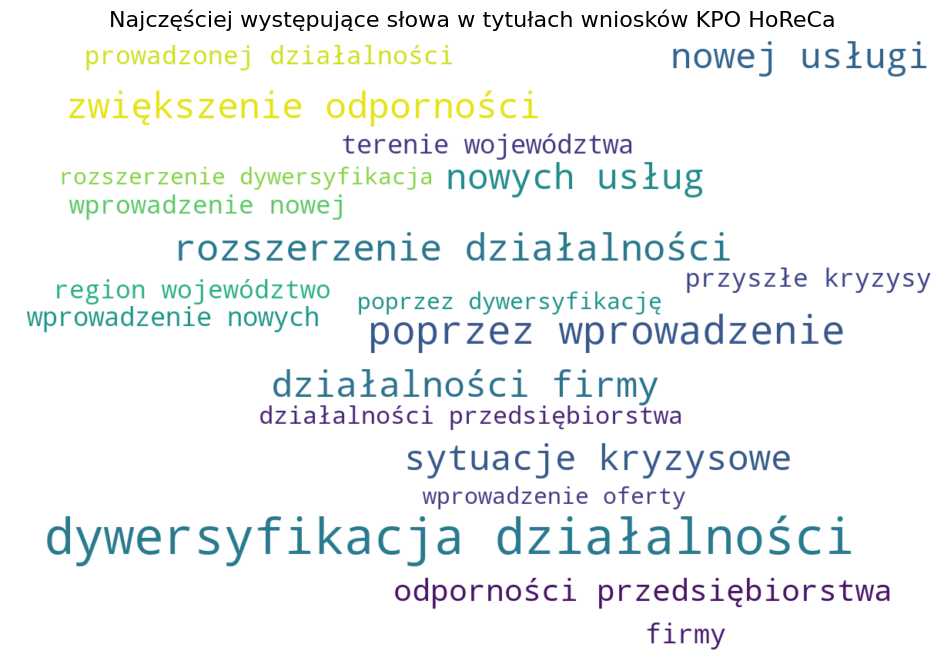

In [39]:
# Funkcja czyszcząca
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-ząćęłńóśźż ]", " ", text)
    tokens = [t for t in text.split() if t not in polish_stopwords and len(t) > 2]
    return " ".join(tokens)

# Oczyszczony tekst z całej kolumny
text_cleaned = " ".join(df_fixed['title'].dropna().apply(clean_text))

# Tworzenie chmury
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=20
).generate(text_cleaned)

# Wyświetlenie
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Najczęściej występujące słowa w tytułach wniosków KPO HoReCa", fontsize=16)
plt.show()

In [40]:
mask_dyw = df_fixed['title'].str.lower().str.contains("dywersyfikacja", na=False)

mean_with = df_fixed.loc[mask_dyw, 'value'].mean()
mean_without = df_fixed.loc[~mask_dyw, 'value'].mean()

print(f"Średnia dotacja (z 'dywersyfikacja'): {mean_with:,.2f} zł")
print(f"Średnia dotacja (bez 'dywersyfikacja'): {mean_without:,.2f} zł")

Średnia dotacja (z 'dywersyfikacja'): 416,778.58 zł
Średnia dotacja (bez 'dywersyfikacja'): 407,543.52 zł


In [41]:
# słownik: słowo -> lista wartości dotacji
word_values = defaultdict(list)

for _, row in df_fixed.dropna(subset=['title', 'value']).iterrows():
    title = row['title'].lower()
    # usuwamy znaki nie-alfabetyczne
    title = re.sub(r"[^a-ząćęłńóśźż\s]", " ", title)
    words = [w for w in title.split() if w and w not in polish_stopwords]
    for w in set(words):  # set() żeby uniknąć powtórzeń w tym samym tytule
        word_values[w].append(row['value'])

# liczymy średnią i liczbę wystąpień
stats = []
for word, values in word_values.items():
    if len(values) >= 5:  # filtr na minimalną liczbę wniosków
        avg_val = sum(values) / len(values)
        stats.append((word, len(values), avg_val))

# sortujemy po średniej malejąco
df_word_stats = pd.DataFrame(stats, columns=['Słowo', 'Liczba wniosków', 'Średnia dotacja (zł)'])
df_word_stats = df_word_stats.sort_values(by='Średnia dotacja (zł)', ascending=False)

print(df_word_stats.head(20))

                 Słowo  Liczba wniosków  Średnia dotacja (zł)
757           otwartym                7         537394.000000
877             eventy                5         537127.800000
741            jachtów               11         535967.636364
647              domki                5         532658.200000
1043           napędem                8         532309.750000
186             teresa                5         526457.000000
685             zakupu               10         523119.100000
660       letniskowych                5         522000.400000
1066  przeciwdziałania                5         521529.800000
1083     zamontowanych                6         520602.500000
122       ograniczenia               10         520458.800000
1084            oparte                8         519134.250000
761        prowadzenie                5         517444.000000
661           wsparcia               12         516603.333333
695           związaną                7         516478.142857
628     

In [42]:
values = df_fixed['value'].dropna()

stats = {
    "Liczba wniosków": len(values),
    "Suma dotacji (zł)": values.sum(),
    "Średnia dotacja (zł)": values.mean(),
    "Mediana dotacji (zł)": values.median(),
    "Min dotacja (zł)": values.min(),
    "Max dotacja (zł)": values.max(),
    "25 percentyl (zł)": values.quantile(0.25),
    "75 percentyl (zł)": values.quantile(0.75),
    "Odchylenie standardowe (zł)": values.std(),
    "Liczba > 500 tys.": (values > 500_000).sum(),
    "Liczba < 100 tys.": (values < 100_000).sum()
}

# prezentacja
for k, v in stats.items():
    print(f"{k}: {v:,.2f}" if isinstance(v, (int, float)) else f"{k}: {v}")

Liczba wniosków: 2,751.00
Suma dotacji (zł): 1131495489
Średnia dotacja (zł): 411,303.34
Mediana dotacji (zł): 452,898.00
Min dotacja (zł): 50000
Max dotacja (zł): 540000
25 percentyl (zł): 323,863.50
75 percentyl (zł): 531,667.50
Odchylenie standardowe (zł): 133,059.54
Liczba > 500 tys.: 1030
Liczba < 100 tys.: 63


In [43]:
def format_currency(x):
    return f"{x:,.0f} zł".replace(",", " ")

# grupowanie po mieście
city_stats = (
    df_fixed.groupby('city', dropna=True)['value']
    .sum()
    .reset_index()
    .sort_values(by='value', ascending=False)
)

# dodajemy kolumnę sformatowaną
city_stats['suma_dotacji'] = city_stats['value'].apply(format_currency)

# top 10 miast
print("TOP 10 miast wg sumy dotacji:")
print(city_stats[['city', 'suma_dotacji']].head(10).to_string(index=False))

# bottom 10 (więcej niż 1 wniosek)
city_counts = df_fixed.groupby('city')['value'].count().reset_index(name='liczba_wniosków')
city_stats_full = city_stats.merge(city_counts, on='city')
bottom_cities = city_stats_full[city_stats_full['liczba_wniosków'] > 1].sort_values(by='value').head(10)
bottom_cities['suma_dotacji'] = bottom_cities['value'].apply(format_currency)

print("\nBOTTOM 10 miast (więcej niż 1 wniosek):")
print(bottom_cities[['city', 'liczba_wniosków', 'suma_dotacji']].to_string(index=False))

TOP 10 miast wg sumy dotacji:
     city   suma_dotacji
 Warszawa 104 552 934 zł
   Kraków  46 821 849 zł
  Wrocław  34 469 839 zł
   Gdańsk  34 398 939 zł
   Poznań  30 938 456 zł
 Szczecin  29 132 405 zł
     Łódź  23 333 969 zł
   Gdynia  18 849 073 zł
   Lublin  14 631 350 zł
Bydgoszcz  14 099 621 zł

BOTTOM 10 miast (więcej niż 1 wniosek):
        city  liczba_wniosków suma_dotacji
    Oświęcim                2   270 756 zł
   Białogard                2   311 196 zł
       Brzeg                2   313 284 zł
    Biłgoraj                2   340 549 zł
        Żory                2   375 462 zł
       Płock                2   386 055 zł
     Staszów                2   407 514 zł
Srebrna Góra                2   425 322 zł
Zduńska Wola                2   431 266 zł
    Jaworzno                2   447 928 zł


In [44]:
# --- Ustaw swoją ramkę danych ---
# Zakładam, że masz df_fixed z kolumnami 'coords' (dict z lat, long) i 'value'

# Funkcja do wyciągania współrzędnych
def extract_lat_lon(val):
    if isinstance(val, dict):
        return val.get('lat'), val.get('long')
    if isinstance(val, str):
        try:
            obj = ast.literal_eval(val)
            if isinstance(obj, dict):
                return obj.get('lat'), obj.get('long')
        except Exception:
            return None, None
    return None, None

if 'lat' not in df_fixed.columns or 'long' not in df_fixed.columns:
    lat_lon = df_fixed['coords'].apply(extract_lat_lon)
    df_fixed['lat'] = [t[0] for t in lat_lon]
    df_fixed['long'] = [t[1] for t in lat_lon]

# --- Przygotowanie danych ---
df_geo = df_fixed.dropna(subset=['lat', 'long', 'value']).copy()
df_geo['lat'] = df_geo['lat'].astype(float)
df_geo['long'] = df_geo['long'].astype(float)
df_geo['value'] = df_geo['value'].astype(float)

# Skalowanie wag (log1p z wartości dotacji)
df_geo['weight'] = np.log1p(df_geo['value'])

# Środek mapy = średnia współrzędnych
center_lat = df_geo['lat'].mean()
center_lon = df_geo['long'].mean()

# Lista punktów [lat, lon, waga]
heat_data = df_geo[['lat', 'long', 'weight']].values.tolist()

# --- Tworzenie mapy ---
m = folium.Map(location=[center_lat, center_lon],
               zoom_start=6,
               tiles="CartoDB positron")

HeatMap(
    heat_data,
    radius=14,
    blur=18,
    max_zoom=6,
    min_opacity=0.25
).add_to(m)

# --- Zapis do pliku ---
m.save("kpo_heatmap.html")
print("Mapa zapisana jako kpo_heatmap.html — otwórz w przeglądarce.")

Mapa zapisana jako kpo_heatmap.html — otwórz w przeglądarce.


In [46]:
# --- Przygotowanie tekstu ---
def normalize_text(s: str) -> str:
    return re.sub(r"[^a-ząćęłńóśźż\s]", " ", str(s).lower())

titles_norm = df_fixed['title'].fillna("").apply(normalize_text)

# --- Lekson: kategorie -> regex (uwzględnia odmiany/słowotwórstwo) ---
LEXICON = OrderedDict([
    ("rozwoj",        r"\brozwó?j\w*|\brozszerze\w*|\bpowiększe\w*|\bzwiększe\w*"),
    ("innowacja",     r"\binnowac\w*|\binnowacyj\w*|\bnowator\w*|\bnowe\s+rozwiąz\w*"),
    ("modernizacja",  r"\bmodernizac\w*|\bunowocześni\w*|\bremont\w*|\bprzebudow\w*"),
    ("cyfryzacja",    r"\bcyfryzac\w*|\bcyfrow\w*|\bdigitalizac\w*|\bwdroż\w+ (it|ict|system\w*)"),
    ("zielona",       r"\bzielon\w*|\bekolog\w*|\boze\w*\s+(energi\w*|źródł\w*)|\btermo\w*"),
    ("dywersyfikacja",r"\bdywersyfikac\w*|\bzróżnicowa\w*"),
    ("poprawa",       r"\bpopraw\w*|\bulepsze\w*|\busprawni\w*|\bpodniesie\w*|\boptymalizac\w*"),
    ("konkurencyjnosc_odpornosc", r"\bkonkurencyj\w*|\bodporno\w*|\bstabilno\w*"),
])

# --- Dopasowania kategorii ---
for cat, pat in LEXICON.items():
    df_fixed[f"kw_{cat}"] = titles_norm.str.contains(pat, regex=True, na=False)

# score = ile kategorii trafiono
flag_cols = [f"kw_{c}" for c in LEXICON.keys()]
df_fixed["sentiment_score"] = df_fixed[flag_cols].sum(axis=1)

# etykieta (lekka)
def label_row(row):
    hits = [cat for cat in LEXICON.keys() if row[f"kw_{cat}"]]
    if not hits:
        return "brak_słów_wartościujących"
    if len(hits) == 1:
        return hits[0]
    return "wiele_kategorii"

df_fixed["sentiment_label"] = df_fixed.apply(label_row, axis=1)

# --- Podsumowanie: metryki finansowe per kategoria ---
summary_rows = []
for cat in ["brak_słów_wartościujących"] + list(LEXICON.keys()) + ["wiele_kategorii"]:
    mask = df_fixed["sentiment_label"].eq(cat)
    if mask.any():
        vals = df_fixed.loc[mask, "value"].dropna().astype(float)
        summary_rows.append({
            "kategoria": cat,
            "liczba_wniosków": int(mask.sum()),
            "udział_%": 100.0 * mask.mean(),
            "średnia_zł": vals.mean() if len(vals) else 0.0,
            "mediana_zł": vals.median() if len(vals) else 0.0,
            "suma_zł": vals.sum() if len(vals) else 0.0,
        })

summary = pd.DataFrame(summary_rows).sort_values("suma_zł", ascending=False)

# formatowanie księgowe
def fmt_money(x): 
    return f"{x:,.0f} zł".replace(",", " ")

summary_formatted = summary.copy()
for col in ["średnia_zł","mediana_zł","suma_zł"]:
    summary_formatted[col] = summary_formatted[col].apply(fmt_money)
summary_formatted["udział_%"] = summary_formatted["udział_%"].map(lambda v: f"{v:.1f}%")

print("Podsumowanie kategorii (wg tytułu):")
print(summary_formatted.to_string(index=False))


Podsumowanie kategorii (wg tytułu):
                kategoria  liczba_wniosków udział_% średnia_zł mediana_zł        suma_zł
          wiele_kategorii             1280    46.5% 415 329 zł 465 030 zł 531 621 456 zł
           dywersyfikacja              667    24.2% 411 732 zł 443 716 zł 274 625 012 zł
                   rozwoj              374    13.6% 399 022 zł 428 970 zł 149 234 179 zł
brak_słów_wartościujących              303    11.0% 404 911 zł 467 887 zł 122 687 930 zł
konkurencyjnosc_odpornosc               59     2.1% 416 156 zł 424 709 zł  24 553 220 zł
                  zielona               22     0.8% 472 373 zł 512 952 zł  10 392 212 zł
             modernizacja               18     0.7% 417 505 zł 473 998 zł   7 515 085 zł
                innowacja               16     0.6% 344 801 zł 374 098 zł   5 516 822 zł
                  poprawa                9     0.3% 421 505 zł 496 293 zł   3 793 546 zł
               cyfryzacja                3     0.1% 518 676 zł 539 090 zł 

C:\Users\kkrzy\AppData\Local\Temp\ipykernel_18236\1930041773.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_fixed[f"kw_{cat}"] = titles_norm.str.contains(pat, regex=True, na=False)
